# Indicator Correlation Filter Example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
from tqdm import tqdm  # noqa: F401

%matplotlib inline
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
#Last edited: 2024029 by JS
import matplotlib.pyplot as plt  # noqa: E402
import poligrain as plg  # noqa: E402

import pypwsqc.pwspyqc_dev_js as pyqc  # noqa: E402


## Data download and preparation

In this example, we use an open PWS dataset from Amsterdam published by de Vos et al. (2019). By running the cell below, a NetCDF-file will be downloaded to your current repository (if your machine is connected to the internet).

In [3]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 5687k  100 5687k    0     0  6290k      0 --:--:-- --:--:-- --:--:-- 11.1M


### Load the PWS data set

In [4]:
ds_pws_orig = xr.open_dataset("OpenSense_PWS_example_format_data.nc")
ds_pws_orig.load()

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
Data variables:
    rainfall   (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

This package handles rainfall data as `xarray`  Datasets. The data set must have `time` and `id` dimensions, `latitude` and `longitude` as coordinates, and `rainfall` as data variable.

An example of how to convert .csv data to a `xarray` dataset is found [here](https://github.com/OpenSenseAction/OS_data_format_conventions/blob/main/notebooks/PWS_example_dataset.ipynb).

### Aggregate PWS data to hourly values

Next we need to aggregate the PWS data to hourly values as the indocator correlation filter by Bárdossy et al. (2021) does not work with 5 minute data

For the aggreation, the new value for an hour is considered as valid if at least 10 out 12 5-min values within one hour have valid data. This can be set by the `min count` parameter.

In [5]:
ds_pws=ds_pws_orig.resample(time='1H').sum(min_count=10)

Add cartesian coordinates to dataset using `poligrain` tools

In [6]:
# if lat /lon istead of latitude/longitude
ds_pws.coords['x'], ds_pws.coords['y'] = plg.spatial.project_point_coordinates(
     ds_pws.longitude, ds_pws.latitude, target_projection="EPSG:25832",
 )
 # for the Netherlands, EPSG 25831 would be correct

Let's look at the first PWS station in the data set, now with x and y coordinates

In [7]:
ds_pws.isel(id=0)

<xarray.Dataset>
Dimensions:    (time: 18265)
Coordinates:
    id         <U6 'ams1'
    elevation  <U3 'nan'
    latitude   float64 52.31
    longitude  float64 4.671
  * time       (time) datetime64[ns] 2016-05-01 ... 2018-06-01
    x          float64 2.049e+05
    y          float64 5.804e+06
Data variables:
    rainfall   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

### Load reference data set

As referecence data for the indicator correlation filter (so called primary stations, c.f. Bárdossy et al. (2021)), 20 time series from pixels from the gauge-adjusteed KNMI radar product over the Amsterdam Metropolitan area were chosen randomly  (Reference?)

The following cell loads this data set and adds cartesian coordinates as shown above

In [8]:
#path needs to be changed for github
ds_ref=xr.open_dataset("./data/RadarRef_AMS.nc")
ds_ref.load()
ds_ref.coords['x'], ds_ref.coords['y'] = plg.spatial.project_point_coordinates(
    ds_ref.lon, ds_ref.lat, target_projection="EPSG:25832",
)
# again for the Netherlands, EPSG 25831 would be correct

## Indicator Correlation Filter

Three different sets distance and indicator correlation matrices need to be calculated. First, we calculate the indicator correlations over distance for the reference data set. This is assumed to be the correct spatial pattern of precipitation which is used for checking the PWS later on.

In [9]:
# Distance and indicator correlations of reference data
dist_mtx_ref, indcorr_mtx_ref = pyqc.calc_indic_corr_all_stns(
    ds_ref.rainfall, 
    ds_ref.rainfall,
    max_distance=30e3, 
    prob=0.99,
    min_valid_overlap=2*24*30,)

  0%|          | 0/20 [00:00<?, ?it/s]/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 20/20 [00:01<00:00, 15.71it/s]


''

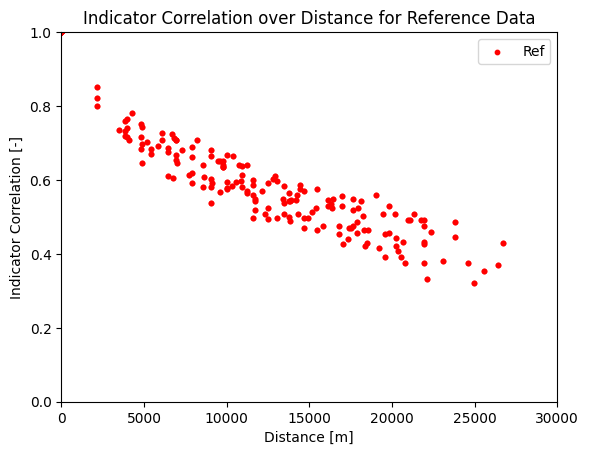

In [10]:
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='red', s=10, label='Ref')
plt.ylim(0, 1)
plt.xlim(0, 30e3)
plt.ylabel('Indicator Correlation [-]')
plt.xlabel('Distance [m]')
plt.title('Indicator Correlation over Distance for Reference Data')
plt.legend()
;

Next we do the same calculations for the PWS.

In [11]:
# Distance and indicator correlations of PWS
dist_mtx_pws, indcorr_mtx_pws = pyqc.calc_indic_corr_all_stns(
    ds_pws.rainfall, 
    ds_pws.rainfall, 
    prob=0.99,
    max_distance=30e3,
    min_valid_overlap=2*24*30,
)

  0%|          | 0/134 [00:00<?, ?it/s]/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 134/134 [00:45<00:00,  2.98it/s]


Let's see how it looks....

''

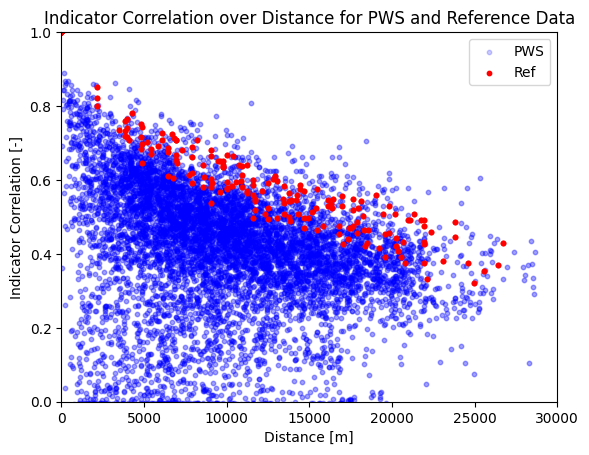

In [12]:
plt.scatter(dist_mtx_pws, indcorr_mtx_pws, color='b', alpha=0.2, s=10, label='PWS')
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='red', s=10, label='Ref')
plt.ylim(0, 1)
plt.xlim(0, 30e3)
plt.ylabel('Indicator Correlation [-]')
plt.xlabel('Distance [m]')
plt.title('Indicator Correlation over Distance for PWS and Reference Data')
plt.legend()
;

We can see that the PWS data is very "noisy", i.e. the indicator correlation of nearby PWS stations is very low which we would not expect from the reference. Such PWS are likely to have data quality issues ans will be removed by the Indicator Correlation Filter.

Finally the distance and indicator correlations matrices between PWS and reference data are calculated.

Note: In contrast to the individual matrices calcualted above, the correct time information is relevant here. In some cases, there might be a shift between the time series (e.g. UTC vs. CET) which yields low and improper indicator correlations. 
Time shifts can be corrected like this:

`ds_ref.rainfall.shift(time=-1)`

In [13]:
dist_mtx_ref_pws, indcorr_mtx_ref_pws= pyqc.calc_indic_corr_all_stns(
    da_a=ds_ref.rainfall,
    da_b=ds_pws.rainfall,
    prob=0.99,
    min_valid_overlap=2*24*30,)

  0%|          | 0/20 [00:00<?, ?it/s]/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


As the calculations of all the matrices may be time consuming depending on the size of the data sets, it may be useful to save these distance and indicator correlation matrices to netCDF-files for further processing

### Application of the indicator correlation filter

In [14]:
indcorr_results = pyqc.indicator_correlation_filter(
    indicator_correlation_matrix_ref=indcorr_mtx_ref,
    distance_correlation_matrix_ref=dist_mtx_ref,
    indicator_correlation_matrix=indcorr_mtx_ref_pws,
    distance_matrix=dist_mtx_ref_pws,
    max_distance=20000,
    bin_size=1000,
    quantile_bin_ref=0.1,
    quantile_bin_pws=0.5,
    threshold=0.05);

/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/github/pypwsqc/src/pypwsqc/pwspyqc_dev_js.py:192: RuntimeWarning: invalid value encountered in scalar divide
  score = sum(IndCorrGood.values * np.array(RankSumWeights)) / NormedWeights
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/home/IWS/seidel/.cache/pypoetry/virtualenvs/pypwsqc-N-_pEr4N-py3.10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _

In [15]:
indcorr_results

<xarray.Dataset>
Dimensions:        (id: 20, id_neighbor: 134)
Coordinates:
  * id             (id) <U2 '0' '1' '2' '3' '4' '5' ... '15' '16' '17' '18' '19'
  * id_neighbor    (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
Data variables:
    indcorr        (id, id_neighbor) float64 0.336 0.3951 ... 0.3014 0.2536
    dist           (id, id_neighbor) float64 2.41e+04 2.38e+04 ... 2.804e+04
    indcorr_good   (id_neighbor) bool True True True True ... True False False
    indcorr_score  (id_neighbor) float64 0.2969 0.4 0.3651 ... 0.08257 0.0 0.0

The results are returned as `xarray.Dataset` with four variables:

`indcorr`: Indicator correlation matrix between `Ref` and `PWS`

`dist`: Distance matrix between `Ref` and `PWS`

`indcorr_good`: Bool Array indicating whether a PWS was accepted ('True') or rejected ('False') by the filter

`indcorr_score`: A metric which indicates how well a PWS fit's into the correlation structure of the Reference

## Analysis of the results 

How may PWS were accepted by the Indicator Correlation Filter?

In [24]:
print (str(indcorr_results.indcorr_good.values.sum()) +' of '+ str(len(indcorr_results.indcorr_good))+ ' PWS were accepted') # noqa: PD011

81 of 134 PWS were accepted


List of accepted PWS

In [17]:
indcorr_results.id_neighbor[indcorr_results.indcorr_good]

<xarray.DataArray 'id_neighbor' (id_neighbor: 81)>
array(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams13', 'ams14', 'ams15', 'ams16', 'ams17', 'ams18', 'ams19', 'ams20',
       'ams21', 'ams22', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams38', 'ams39',
       'ams40', 'ams47', 'ams50', 'ams51', 'ams52', 'ams53', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams72', 'ams75', 'ams81', 'ams82',
       'ams86', 'ams88', 'ams89', 'ams90', 'ams91', 'ams94', 'ams95', 'ams96',
       'ams98', 'ams100', 'ams101', 'ams102', 'ams103', 'ams104', 'ams106',
       'ams107', 'ams108', 'ams109', 'ams110', 'ams112', 'ams113', 'ams114',
       'ams115', 'ams117', 'ams118', 'ams120', 'ams123', 'ams125', 'ams128',
       'ams129', 'ams131', 'ams132'], dtype='<U6')
Coordinates:
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams131' 'ams132'

### A closer look at the results 


**PWS 'ams74'**

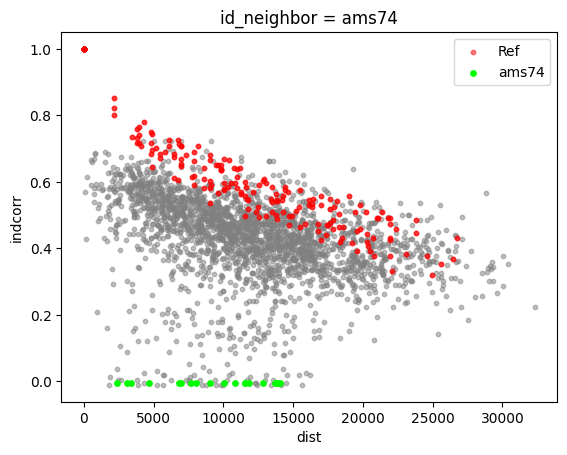

In [18]:
indcorr_results.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
#foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', alpha=0.5, s=10, label='Ref')
indcorr_results.sel(id_neighbor='ams74').plot.scatter(x='dist', y='indcorr', color='lime', s=15, label='ams74')
plt.legend();

The PWS 'ams74' has a very low indicator correlation with all reference stations. The reason for is is the high amount of 0mm precipitation in the data set. Therefore it did not pass the filter.

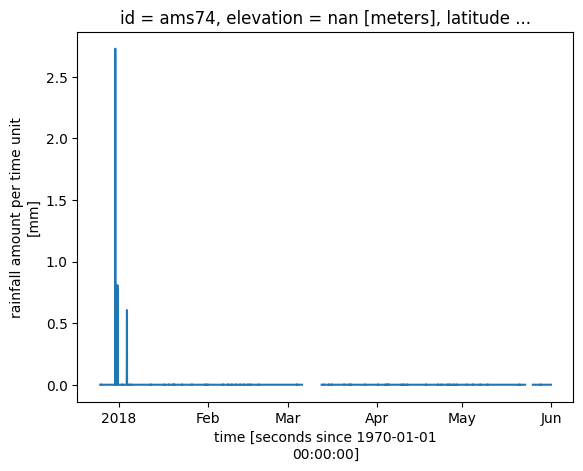

In [19]:
ds_pws.sel(id=['ams74']).rainfall.plot();

**PWS 'ams134'**

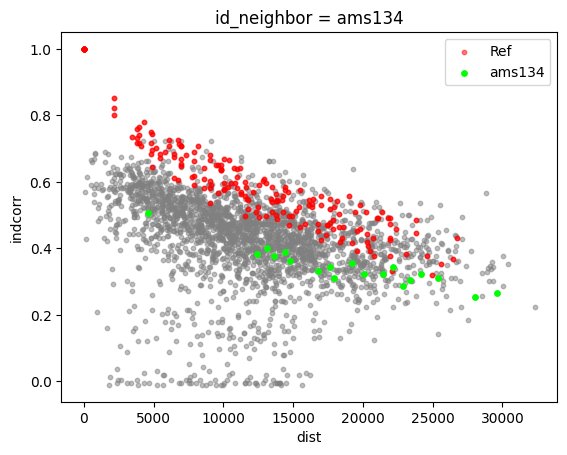

In [20]:
indcorr_results.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
#foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', alpha=0.5, s=10, label='Ref')
indcorr_results.sel(id_neighbor='ams134').plot.scatter(x='dist', y='indcorr', color='lime', s=15, label='ams134')
plt.legend();

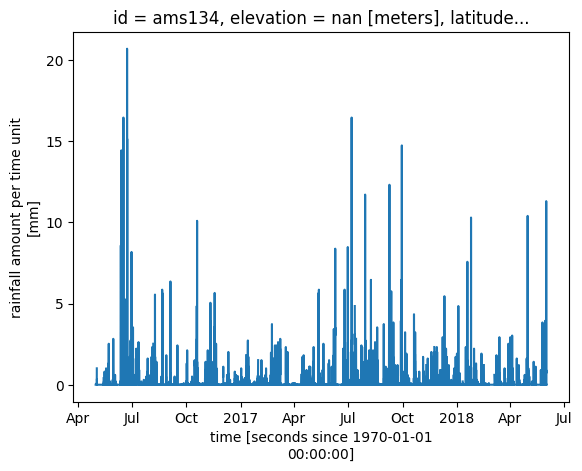

In [21]:
ds_pws.sel(id=['ams134']).rainfall.plot();

PWS 'ams134' has lower indicator correlations up to 20 km (this was set as parameter) than the reference stations although the precipitation time series is complete and without any unrealstic values. This might be caused by incorrect location of ths specific PWS.

**PWS 'ams113'**

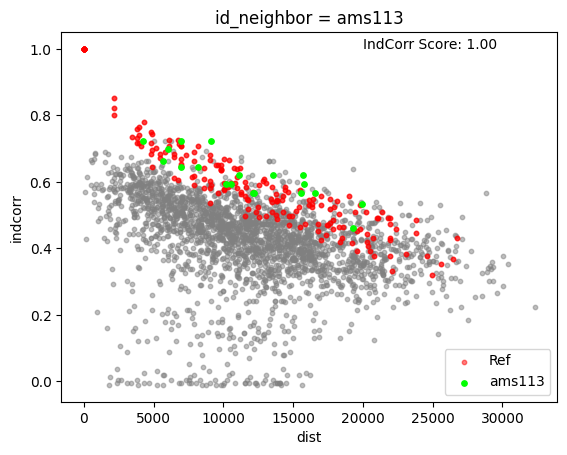

In [22]:
indcorr_results.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
#foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', alpha=0.5, s=10, label='Ref')
indcorr_results.sel(id_neighbor='ams113').plot.scatter(x='dist', y='indcorr', color='lime', s=15, label='ams113')
IndCorr_Score= str("{:.2f}".format(indcorr_results.sel(id_neighbor='ams113').indcorr_score.values))
plt.legend()
plt.text(20000,1, 'IndCorr Score: '+IndCorr_Score);

This PWS has a very good indicator correlation with all references. The Indicator Correlation Score is a metric for showing how well a specific PWS fits to the indicator correlation structure of the reference data. A score of 1.0 means that for each chosen bin, the indicator corrleation of PWS is at least as good as the reference. 

**PWS 'ams36'**

Here's an example of a PWS that passed the indicator correlation filter but the Indicator Correlation Score is lower, which is due to fact that the indicator corrleation of the PWS is lower than the reference for distances < 5000m 

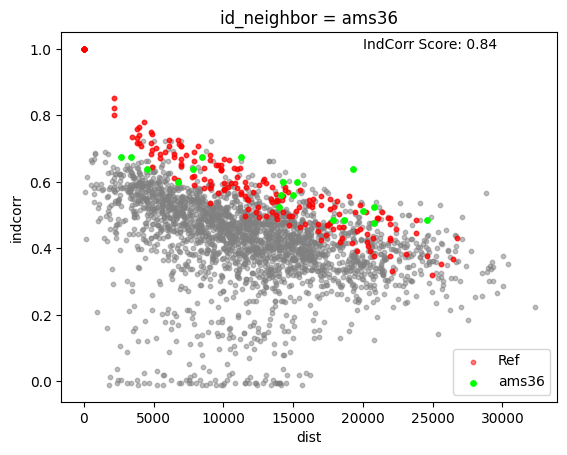

In [23]:
indcorr_results.plot.scatter(x='dist', y='indcorr', color='grey', alpha=0.5, s=10)
#foo.where(foo.indcorr_good).plot.scatter(x='dist', y='indcorr', color='b', alpha=0.4, s=3)
plt.scatter(dist_mtx_ref, indcorr_mtx_ref, color='r', alpha=0.5, s=10, label='Ref')
indcorr_results.sel(id_neighbor='ams36').plot.scatter(x='dist', y='indcorr', color='lime', s=15, label='ams36')
IndCorr_Score= str("{:.2f}".format(indcorr_results.sel(id_neighbor='ams36').indcorr_score.values))
plt.legend()
plt.text(20000,1, 'IndCorr Score: '+IndCorr_Score);